<a href="https://colab.research.google.com/github/sdikici/Demand_Forecasting_Prophet_DeepAR/blob/main/Prophet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d sercandikici/merged-dataset-electricty-weather-for-modelling
! unzip merged-dataset-electricty-weather-for-modelling.zip

  0% 0.00/189k [00:00<?, ?B/s]
100% 189k/189k [00:00<00:00, 7.49MB/s]
Archive:  merged-dataset-electricty-weather-for-modelling.zip
  inflating: merged_data.csv         


In [239]:
from prophet import Prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [240]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return mape

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def r_squared(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mean_y_true = np.mean(y_true)
    ss_total = np.sum((y_true - mean_y_true) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2


In [241]:
df_merged = pd.read_csv("merged_data.csv")
df_merged['settlement_date'] = pd.to_datetime(df_merged['settlement_date'])
df_merged["tsd"] = np.square(df_merged["tsd"])
df_merged

,settlement_date,tsd,is_holiday,temp
0,2021-01-01 00:00:00,28552.00,1.0,1.55
1,2021-01-01 02:00:00,26579.75,1.0,1.60
2,2021-01-01 04:00:00,25236.00,1.0,0.55
3,2021-01-01 06:00:00,25792.25,1.0,-0.35
4,2021-01-01 08:00:00,28162.75,1.0,-0.10
...,...,...,...,...
13136,2023-12-31 16:00:00,34006.00,0.0,7.60
13137,2023-12-31 18:00:00,32273.00,0.0,8.20
13138,2023-12-31 20:00:00,27456.50,0.0,8.45
13139,2023-12-31 22:00:00,24139.25,0.0,8.35


Model 1 predict 7 days in the future

In [242]:
df_model_1 = df_merged[["tsd","settlement_date"]]
df_model_1.columns=["y","ds"]
df_model_1

,y,ds
0,28552.00,2021-01-01 00:00:00
1,26579.75,2021-01-01 02:00:00
2,25236.00,2021-01-01 04:00:00
3,25792.25,2021-01-01 06:00:00
4,28162.75,2021-01-01 08:00:00
...,...,...
13136,34006.00,2023-12-31 16:00:00
13137,32273.00,2023-12-31 18:00:00
13138,27456.50,2023-12-31 20:00:00
13139,24139.25,2023-12-31 22:00:00


train test split

In [243]:
split_from = 90*12 #train test split is from 90days

train_data = df_model_1[:-split_from]
test_data = df_model_1[-split_from:]
print(train_data.shape)
print(test_data.shape)

(12061, 2)
(1080, 2)


train parameters

In [244]:
freq = "2H"
seasonality_prior_scale = 0.01
changepoint_prior_scale = 0.05
days_to_predict=7
periods = days_to_predict*12
mcmc_samples = 50

Train the model

In [245]:
m = Prophet(mcmc_samples=mcmc_samples, changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale)
m.fit(train_data)

future_1 = m.make_future_dataframe(periods=periods , freq=freq)

DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcrdr7yv0/h_q0i18s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcrdr7yv0/e4qd3zbp.json
11:23:32 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=96616', 'data', 'file=/tmp/tmpcrdr7yv0/h_q0i18s.json', 'init=/tmp/tmpcrdr7yv0/e4qd3zbp.json', 'output', 'file=/tmp/tmpcrdr7yv0/prophet_model8yeezhqw/prophet_model-20240427112332_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=96616', 'data', 'file=/tmp/tmpcrdr7yv0/h_q0i18s.json', 'init=/tmp/tmpcrdr7yv0/e4qd3zbp.json', 'output', 'file=/tmp/tmpcrdr7yv0/prophet_model8yeezhqw/prophet_model-20240427112332_2.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

11:23:44 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=96616', 'data', 'file=/tmp/tmpcrdr7yv0/h_q0i18s.json', 'init=/tmp/tmpcrdr7yv0/e4qd3zbp.json', 'output', 'file=/tmp/tmpcrdr7yv0/prophet_model8yeezhqw/prophet_model-20240427112332_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpcrdr7yv0/prophet_model8yeezhqw/prophet_model-20240427112332_1.csv
 console_msgs (if any):
	/tmp/tmpcrdr7yv0/prophet_model8yeezhqw/prophet_model-20240427112332_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 25
    num_warmup = 25
    save_warmup = 0 (Default)
    thin = 1 (Default)


In [246]:
#create forecasts
forecast_1 = m.predict(future_1)
forecast_1.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
12140,2023-10-09 16:00:00,26922.736852,26166.655472,35169.041457,26723.009333,27122.434692,3547.662344,3319.784318,3794.847519,3796.818267,...,984.074132,848.713347,1083.124225,-1233.230055,-1386.612440,-1024.778854,0.0,0.0,0.0,30470.399196
12141,2023-10-09 18:00:00,26922.155767,28081.616446,36197.225463,26722.279043,27121.933738,5294.352223,5123.770684,5550.740953,5418.904393,...,1102.724736,980.466158,1200.234486,-1227.276907,-1382.296682,-1020.384964,0.0,0.0,0.0,32216.507990
12142,2023-10-09 20:00:00,26921.574683,25550.391271,34073.611945,26721.548754,27121.432784,2650.946172,2417.023628,2878.348285,2678.104520,...,1194.140653,1089.030641,1287.908264,-1221.299000,-1377.948675,-1015.998862,0.0,0.0,0.0,29572.520855
12143,2023-10-09 22:00:00,26920.993598,20741.196752,29184.465289,26720.818465,27120.923249,-1850.925567,-2072.889984,-1617.889644,-1896.094725,...,1260.465620,1146.833194,1348.312348,-1215.296462,-1373.568275,-1011.620317,0.0,0.0,0.0,25070.068031
12144,2023-10-10 00:00:00,26920.412513,18288.190409,26947.899791,26720.088176,27120.411598,-4118.301448,-4380.261742,-3863.288547,-4213.475635,...,1304.443605,1189.052920,1384.382270,-1209.269419,-1369.155342,-1007.613700,0.0,0.0,0.0,22802.111065


In [247]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast_1)


In [248]:
forecast_days = forecast_1[forecast_1["ds"] >= test_data["ds"].iloc[0]]
test_days = test_data[(test_data["ds"] >= test_data["ds"].iloc[0])&(test_data["ds"] <= forecast_days["ds"].iloc[-1])]

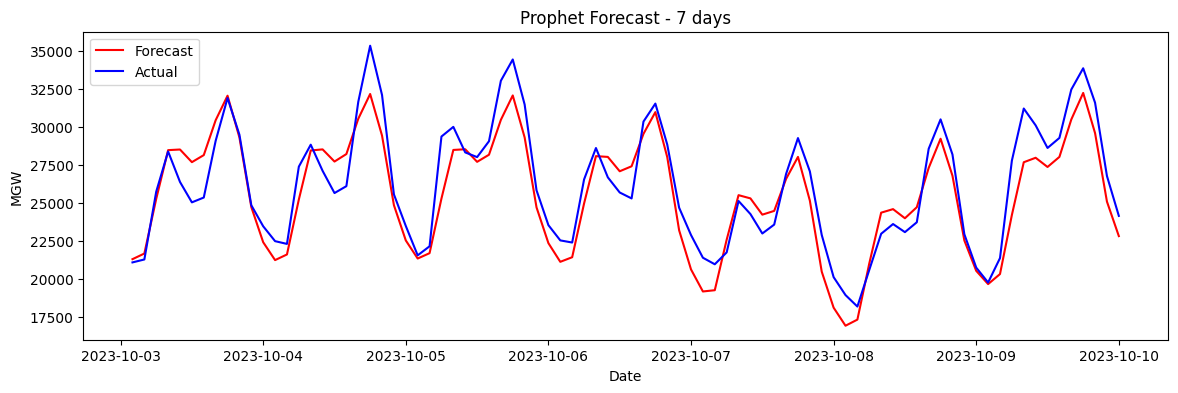

In [249]:
def forecast_plot(forecast_days,test_days, days):

  fig, ax = plt.subplots(figsize=(14, 4))
  ax.plot(forecast_days['ds'], forecast_days['yhat'], label='Forecast', color='red')
  ax.plot(test_days['ds'], test_days['y'], label='Actual', color='blue')
  ax.set_xlabel('Date')
  ax.set_ylabel('MGW')
  plt.title(f'Prophet Forecast - {days} days')
  plt.legend()
  plt.show()

forecast_plot(forecast_days,test_days,days_to_predict)

In [250]:
mape_1 = mean_absolute_percentage_error(test_days["y"],forecast_days["yhat"])
rmse_1 = root_mean_squared_error(test_days["y"],forecast_days["yhat"])
rsqr_1 = r_squared(test_days["y"],forecast_days["yhat"])
print(f"MAPE without regressors: {round(mape_1,7)}")
print(f"RMSE without regressors: {round(rmse_1,7)}")
print(f"R-squared without regressors: {round(rsqr_1,7)}")

MAPE without regressors: 0.0508856
RMSE without regressors: 1596.9517346
R-squared without regressors: 0.8346896


training model_2, additional holidays

In [251]:
m2 = Prophet(mcmc_samples=mcmc_samples, changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale)
m2.add_country_holidays(country_name="UK")
m2.fit(train_data)

future_2 = m2.make_future_dataframe(periods=periods , freq=freq)
forecast2 = m2.predict(future_2)
forecast2

DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcrdr7yv0/a620rikk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcrdr7yv0/umq8i7fe.json
11:23:52 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=86507', 'data', 'file=/tmp/tmpcrdr7yv0/a620rikk.json', 'init=/tmp/tmpcrdr7yv0/umq8i7fe.json', 'output', 'file=/tmp/tmpcrdr7yv0/prophet_modelnl_5cjio/prophet_model-20240427112352_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=86507', 'data', 'file=/tmp/tmpcrdr7yv0/a620rikk.json', 'init=/tmp/tmpcrdr7yv0/umq8i7fe.json', 'output', 'file=/tmp/tmpcrdr7yv0/prophet_modelnl_5cjio/prophet_model-20240427112352_2.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

11:27:27 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=86507', 'data', 'file=/tmp/tmpcrdr7yv0/a620rikk.json', 'init=/tmp/tmpcrdr7yv0/umq8i7fe.json', 'output', 'file=/tmp/tmpcrdr7yv0/prophet_modelnl_5cjio/prophet_model-20240427112352_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpcrdr7yv0/prophet_modelnl_5cjio/prophet_model-20240427112352_1.csv
 console_msgs (if any):
	/tmp/tmpcrdr7yv0/prophet_modelnl_5cjio/prophet_model-20240427112352_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 25
    num_warmup = 25
    save_warmup = 0 (Default)
    thin = 1 (Default)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Boxing Day,Boxing Day_lower,Boxing Day_upper,Boxing Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01 00:00:00,30481.298542,23334.120337,32372.801509,30199.147667,31110.775615,0.0,0.0,0.0,0.0,...,1033.599236,853.613649,1163.636115,1721.065083,1398.249573,2402.690576,0.0,0.0,0.0,27927.626320
1,2021-01-01 02:00:00,30480.481680,21928.221456,31644.246978,30198.561437,31109.148579,0.0,0.0,0.0,0.0,...,984.369188,801.506287,1120.513129,1727.032728,1406.731269,2405.962682,0.0,0.0,0.0,26673.913400
2,2021-01-01 04:00:00,30479.664819,22188.156024,31600.940303,30197.975206,31107.521543,0.0,0.0,0.0,0.0,...,922.908958,741.815382,1043.235685,1733.308797,1415.257047,2409.510893,0.0,0.0,0.0,26968.120769
3,2021-01-01 06:00:00,30478.847957,25991.081467,35441.399809,30197.388975,31105.894507,0.0,0.0,0.0,0.0,...,846.747963,672.187791,969.941179,1739.892347,1424.406936,2413.334449,0.0,0.0,0.0,30547.165481
4,2021-01-01 08:00:00,30478.031096,29321.589517,38131.317287,30196.802744,31104.267471,0.0,0.0,0.0,0.0,...,753.516821,590.217833,871.711367,1746.782391,1433.863540,2417.432557,0.0,0.0,0.0,33645.699597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12140,2023-10-09 16:00:00,26987.375130,25962.454668,35007.711621,26716.054913,27293.757567,0.0,0.0,0.0,0.0,...,1050.136877,940.800342,1186.333743,-1152.179057,-1574.748811,-538.564083,0.0,0.0,0.0,30680.812996
12141,2023-10-09 18:00:00,26986.749251,27746.906597,37205.961532,26715.356397,27293.316199,0.0,0.0,0.0,0.0,...,1161.575498,1055.581477,1292.187342,-1146.161915,-1570.059671,-532.996678,0.0,0.0,0.0,32425.085078
12142,2023-10-09 20:00:00,26986.123371,25039.434954,34361.608654,26714.657881,27292.874831,0.0,0.0,0.0,0.0,...,1245.221639,1146.609871,1379.592194,-1140.122175,-1565.317645,-527.410333,0.0,0.0,0.0,29733.172768
12143,2023-10-09 22:00:00,26985.497492,20325.094835,29737.262159,26713.959365,27292.433463,0.0,0.0,0.0,0.0,...,1303.412385,1208.849626,1437.652536,-1134.059964,-1560.522517,-521.805144,0.0,0.0,0.0,25228.994506


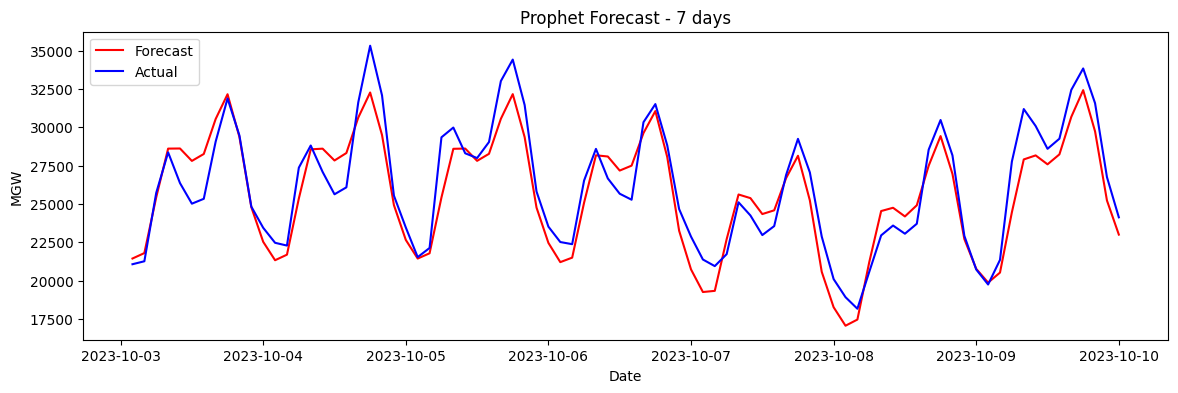

In [252]:
forecast2__days = forecast2[forecast2 ["ds"] >= test_data["ds"].iloc[0]]
forecast_plot(forecast2__days,test_days,days_to_predict)

In [253]:
mape_2 = mean_absolute_percentage_error(test_days["y"],forecast2__days["yhat"])
rmse_2 = root_mean_squared_error(test_days["y"],forecast2__days["yhat"])
rsqr_2 = r_squared(test_days["y"],forecast2__days["yhat"])
print(f"MAPE holidays added: {round(mape_2,7)}")
print(f"RMSE holidays added: {round(rmse_2,7)}")
print(f"R-squared holidays added: {round(rsqr_2,7)}")

MAPE holidays added: 0.0489096
RMSE holidays added: 1540.8670698
R-squared holidays added: 0.8460971


model 3 holiday+weather data

In [254]:
df_model_3 = df_merged[["tsd","settlement_date","temp"]]
df_model_3.columns=["y","ds","temp"]
df_model_3

,y,ds,temp
0,28552.00,2021-01-01 00:00:00,1.55
1,26579.75,2021-01-01 02:00:00,1.60
2,25236.00,2021-01-01 04:00:00,0.55
3,25792.25,2021-01-01 06:00:00,-0.35
4,28162.75,2021-01-01 08:00:00,-0.10
...,...,...,...
13136,34006.00,2023-12-31 16:00:00,7.60
13137,32273.00,2023-12-31 18:00:00,8.20
13138,27456.50,2023-12-31 20:00:00,8.45
13139,24139.25,2023-12-31 22:00:00,8.35


In [255]:
train_data_3 = df_model_3[:-split_from]
test_data_3 = df_model_3[-split_from:]

In [256]:
m3= Prophet(mcmc_samples=mcmc_samples, changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale)
m3.add_country_holidays(country_name="UK")
m3.add_regressor("temp", mode="additive")
m3.fit(train_data_3)

future3 = m3.make_future_dataframe(periods=periods, freq=freq)



DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcrdr7yv0/huh9yn9r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcrdr7yv0/k7ws2kqq.json
11:27:36 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=63333', 'data', 'file=/tmp/tmpcrdr7yv0/huh9yn9r.json', 'init=/tmp/tmpcrdr7yv0/k7ws2kqq.json', 'output', 'file=/tmp/tmpcrdr7yv0/prophet_modeltixb2uvj/prophet_model-20240427112736_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=63333', 'data', 'file=/tmp/tmpcrdr7yv0/huh9yn9r.json', 'init=/tmp/tmpcrdr7yv0/k7ws2kqq.json', 'output', 'file=/tmp/tmpcrdr7yv0/prophet_modeltixb2uvj/prophet_model-20240427112736_2.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanp

11:27:50 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=63333', 'data', 'file=/tmp/tmpcrdr7yv0/huh9yn9r.json', 'init=/tmp/tmpcrdr7yv0/k7ws2kqq.json', 'output', 'file=/tmp/tmpcrdr7yv0/prophet_modeltixb2uvj/prophet_model-20240427112736_1.csv', 'method=sample', 'num_samples=25', 'num_warmup=25', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpcrdr7yv0/prophet_modeltixb2uvj/prophet_model-20240427112736_1.csv
 console_msgs (if any):
	/tmp/tmpcrdr7yv0/prophet_modeltixb2uvj/prophet_model-20240427112736_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 25
    num_warmup = 25
    save_warmup = 0 (Default)
    thin = 1 (Default)


In [257]:
#create train and text idx which will be used to index future dataframe
train_idx = future3["ds"].isin(train_data_3.ds)
test_idx = ~train_idx

#add regressors to future dataframe

reg = ["temp"]
for r in reg:
  future3.loc[train_idx, r] = train_data_3[r].to_list()

for r in reg:
  future3.loc[test_idx, r] = test_data_3.iloc[:periods][r].to_list()

future3

,ds,temp
0,2021-01-01 00:00:00,1.55
1,2021-01-01 02:00:00,1.60
2,2021-01-01 04:00:00,0.55
3,2021-01-01 06:00:00,-0.35
4,2021-01-01 08:00:00,-0.10
...,...,...
12140,2023-10-09 16:00:00,24.15
12141,2023-10-09 18:00:00,19.95
12142,2023-10-09 20:00:00,16.70
12143,2023-10-09 22:00:00,16.30


In [258]:
forecast3 = m3.predict(future3)
forecast3

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Boxing Day,Boxing Day_lower,Boxing Day_upper,Boxing Day (observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01 00:00:00,29792.275925,25696.694867,34867.195303,29541.995493,29980.867997,0.0,0.0,0.0,0.0,...,1093.224631,978.053747,1197.320420,228.995726,98.769142,415.305068,0.0,0.0,0.0,30158.157767
1,2021-01-01 02:00:00,29791.875039,24399.668176,33217.622813,29541.682932,29980.430356,0.0,0.0,0.0,0.0,...,1040.877621,928.120624,1152.014968,234.371141,104.143115,419.758505,0.0,0.0,0.0,28726.928325
2,2021-01-01 04:00:00,29791.474152,24565.495712,33603.112629,29541.370371,29979.992714,0.0,0.0,0.0,0.0,...,976.259601,856.244963,1086.806774,240.001394,109.783773,424.439123,0.0,0.0,0.0,29179.158566
3,2021-01-01 06:00:00,29791.073266,28051.343590,37397.395236,29541.057810,29979.555073,0.0,0.0,0.0,0.0,...,896.889783,777.979247,1022.874559,245.885648,115.690163,429.346069,0.0,0.0,0.0,32974.602189
4,2021-01-01 08:00:00,29790.672380,31855.626473,40752.477900,29540.745250,29979.117432,0.0,0.0,0.0,0.0,...,800.383405,682.176136,941.951587,252.023026,121.861295,434.478461,0.0,0.0,0.0,36335.240961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12140,2023-10-09 16:00:00,26732.581485,23785.062442,32555.301417,26594.376975,26902.844576,0.0,0.0,0.0,0.0,...,966.981979,857.032415,1063.678357,-949.784735,-1205.079031,-786.299730,0.0,0.0,0.0,27955.342572
12141,2023-10-09 18:00:00,26731.889729,26309.175839,35306.464932,26593.559958,26902.226221,0.0,0.0,0.0,0.0,...,1082.411710,980.792975,1186.170004,-945.827339,-1200.287610,-783.541847,0.0,0.0,0.0,30605.759638
12142,2023-10-09 20:00:00,26731.197974,24394.823801,33459.367227,26592.742941,26901.607867,0.0,0.0,0.0,0.0,...,1170.763676,1074.289814,1279.892203,-941.832516,-1195.448732,-780.763045,0.0,0.0,0.0,28581.872622
12143,2023-10-09 22:00:00,26730.506218,19566.639585,28584.041822,26591.933700,26900.989512,0.0,0.0,0.0,0.0,...,1234.361991,1139.300018,1349.037890,-937.800468,-1190.562688,-777.963335,0.0,0.0,0.0,23918.370497


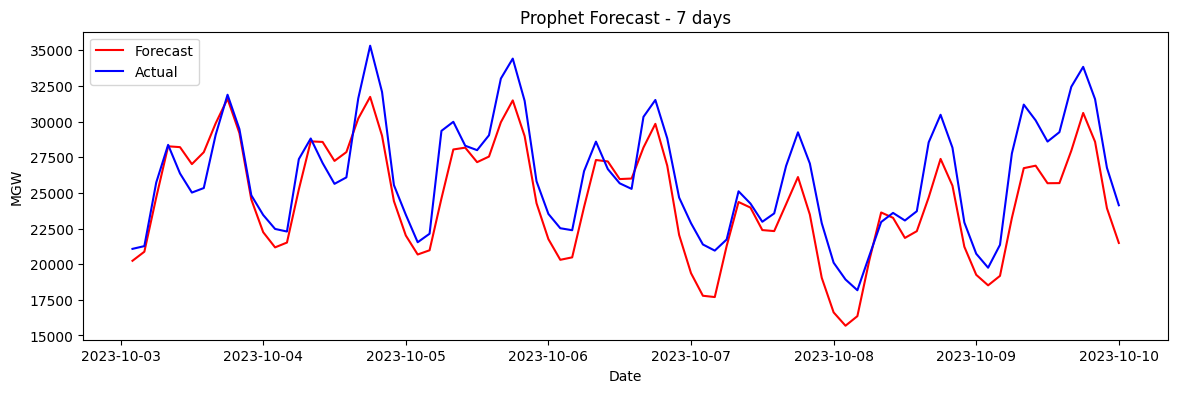

In [259]:
forecast3_days = forecast3[forecast3["ds"] >= test_data_3["ds"].iloc[0]]
test3_days = test_data_3[(test_data_3["ds"] >= test_data_3["ds"].iloc[0])&(test_data_3["ds"] <= forecast3_days["ds"].iloc[-1])]
forecast_plot(forecast3_days,test3_days,days_to_predict)

In [260]:
mape_3 = mean_absolute_percentage_error(test3_days["y"],forecast3_days["yhat"])
rmse_3 = root_mean_squared_error(test3_days["y"],forecast3_days["yhat"])
rsqr_3 = r_squared(test3_days["y"],forecast3_days["yhat"])
print(f"MAPE holidays+weather added: {round(mape_3,7)}")
print(f"RMSE holidays+weather added: {round(rmse_3,7)}")
print(f"R-squared holidays+weather added: {round(rsqr_3,7)}")

MAPE holidays+weather added: 0.0739377
RMSE holidays+weather added: 2286.747863
R-squared holidays+weather added: 0.6610364


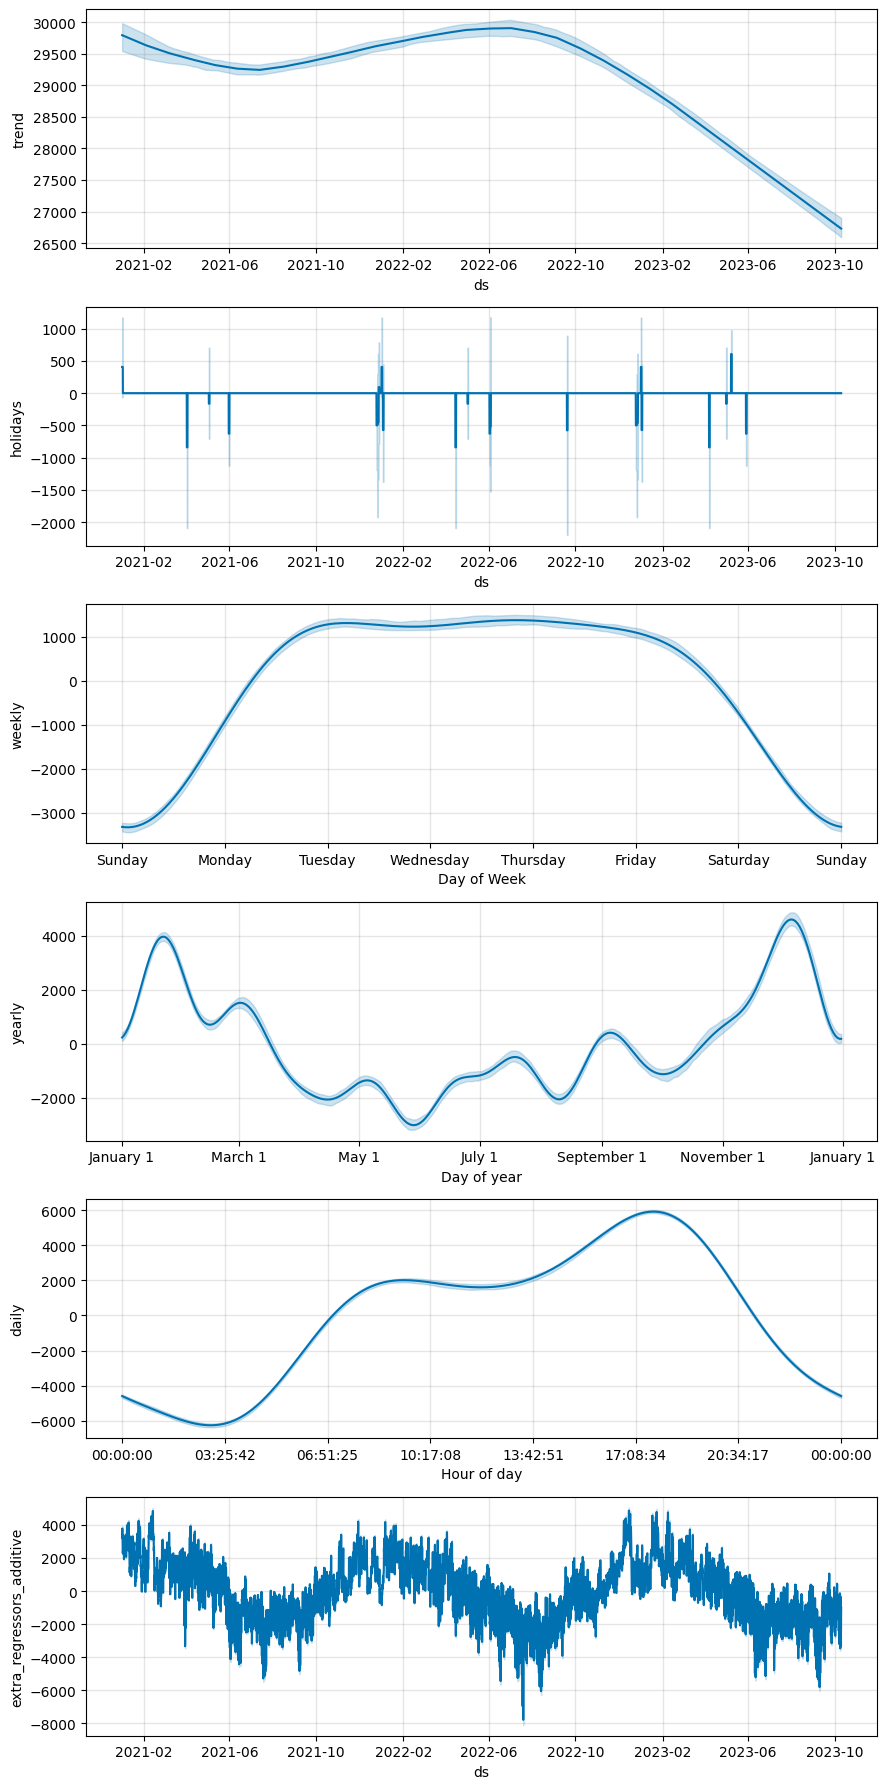

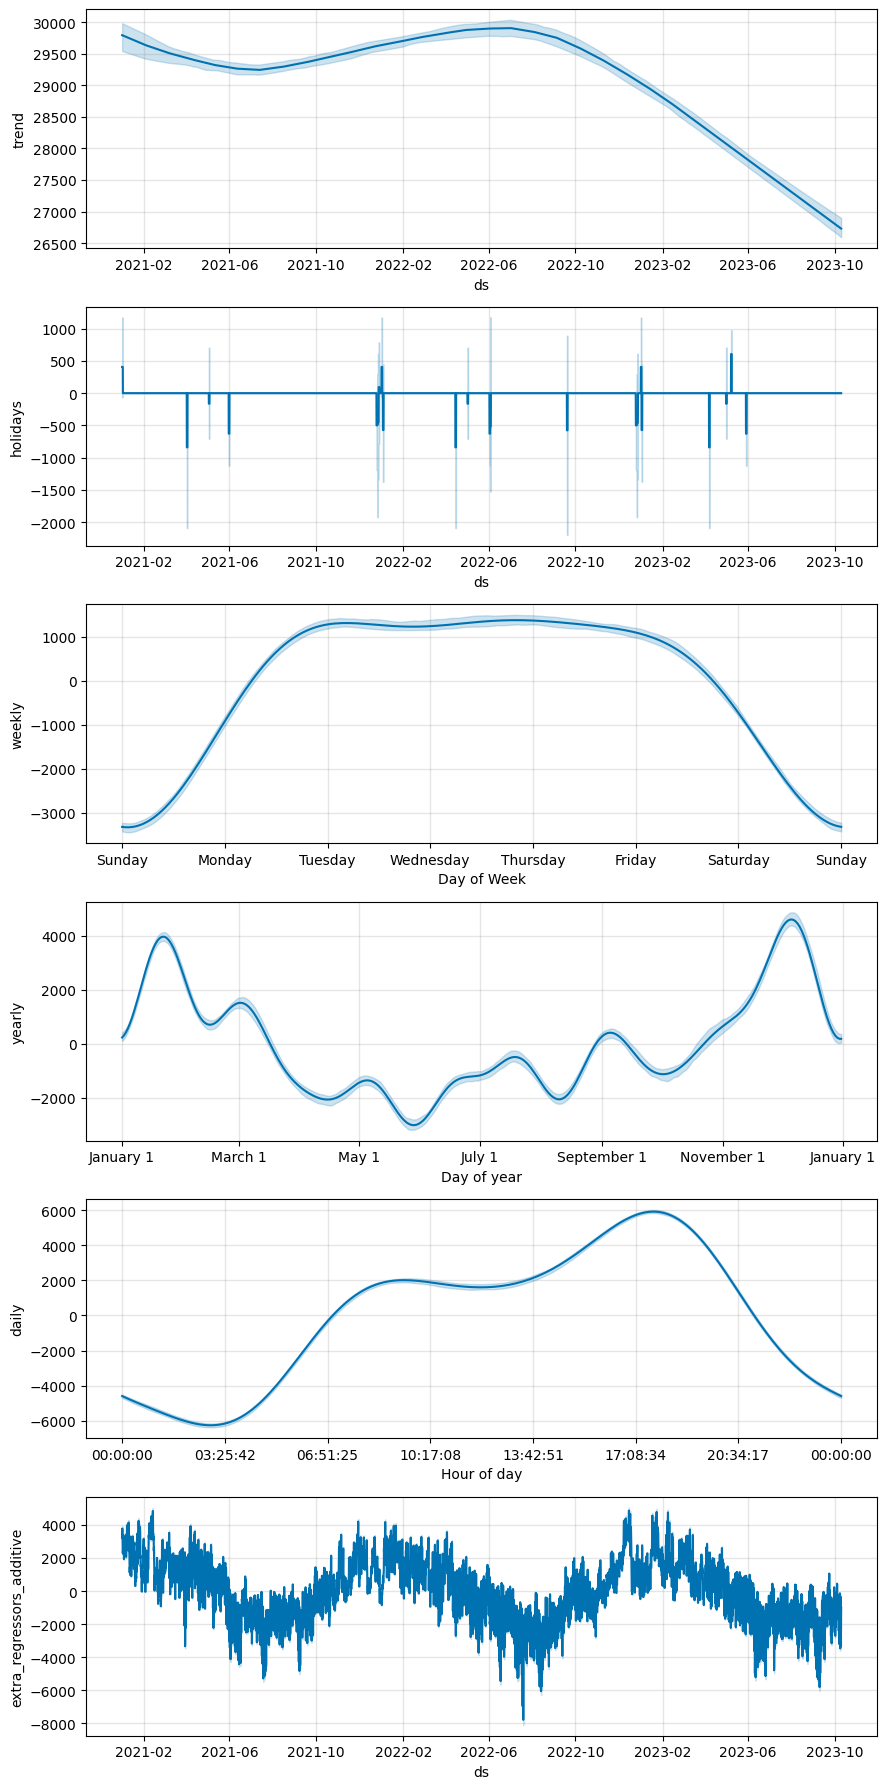

In [261]:
m3.plot_components(forecast3)